Installing prerequisites and loading libraries

In [2]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from tensorflow.keras.utils import load_img

In [5]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pydicom as dcm
import math
from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input 
import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence

Loading Data and EDA

In [6]:
labelsdf = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pneumonia_Challenge/stage_2_train_labels.csv")

In [7]:
labelsdf.shape

(30227, 6)

In [8]:
labelsdf.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [9]:
labelsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [10]:
labelsdf.Target.value_counts()

0    20672
1     9555
Name: Target, dtype: int64

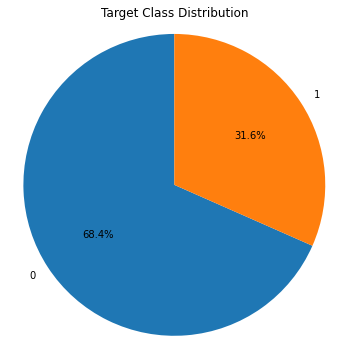

In [17]:
label_count=labelsdf['Target'].value_counts()
fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(label_count.values, labels=label_count.index, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal') 
plt.title('Target Class Distribution')
plt.show()

In [11]:
classdf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pneumonia_Challenge/stage_2_detailed_class_info.csv')

In [12]:
classdf

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,Normal
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity


In [13]:
classdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


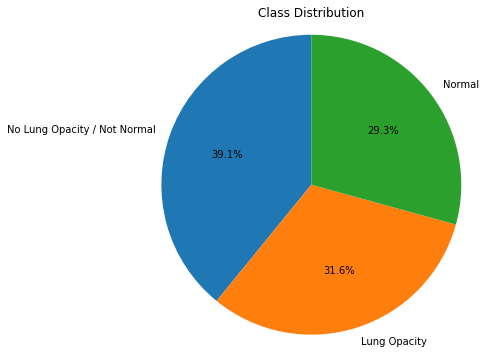

In [14]:
label_count=classdf['class'].value_counts()
fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

Checking for Duplicates

In [15]:
duplicateRowsDF = labelsdf[labelsdf.duplicated(['patientId'])]

In [16]:
duplicateRowsDF

,patientId,x,y,width,height,Target
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
15,00aecb01-a116-45a2-956c-08d2fa55433f,547.0,299.0,119.0,165.0,1
17,00c0b293-48e7-4e16-ac76-9269ba535a62,650.0,511.0,206.0,284.0,1
20,00f08de1-517e-4652-a04f-d1dc9ee48593,571.0,275.0,230.0,476.0,1
...,...,...,...,...,...,...
30209,c18d1138-ba74-4af5-af21-bdd4d2c96bb5,295.0,473.0,133.0,176.0,1
30215,c1cddf32-b957-4753-acaa-472ab1447e86,766.0,475.0,135.0,213.0,1
30220,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,316.0,504.0,179.0,273.0,1
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1


In [18]:
labelsdf[labelsdf.patientId=='c18d1138-ba74-4af5-af21-bdd4d2c96bb5']

,patientId,x,y,width,height,Target
30208,c18d1138-ba74-4af5-af21-bdd4d2c96bb5,646.0,386.0,141.0,206.0,1
30209,c18d1138-ba74-4af5-af21-bdd4d2c96bb5,295.0,473.0,133.0,176.0,1


In [19]:
labelsdf[labelsdf.patientId=='00aecb01-a116-45a2-956c-08d2fa55433f']

,patientId,x,y,width,height,Target
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1
15,00aecb01-a116-45a2-956c-08d2fa55433f,547.0,299.0,119.0,165.0,1


From the above we can observe that though the patientID is same we can say that other parameter are different indicating that the repitition is because of same patient have more than one bounding box in the same Dicom image.

In [20]:
duplicateClassRowsDF = classdf[classdf.duplicated(['patientId'])]

In [21]:
duplicateClassRowsDF

,patientId,class
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
15,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity
17,00c0b293-48e7-4e16-ac76-9269ba535a62,Lung Opacity
20,00f08de1-517e-4652-a04f-d1dc9ee48593,Lung Opacity
...,...,...
30209,c18d1138-ba74-4af5-af21-bdd4d2c96bb5,Lung Opacity
30215,c1cddf32-b957-4753-acaa-472ab1447e86,Lung Opacity
30220,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,Lung Opacity
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity


In [22]:
classdf[classdf.patientId=='c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8']

,patientId,class
30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity


In [23]:
classdf[classdf.patientId=='c1cddf32-b957-4753-acaa-472ab1447e86']

,patientId,class
30214,c1cddf32-b957-4753-acaa-472ab1447e86,Lung Opacity
30215,c1cddf32-b957-4753-acaa-472ab1447e86,Lung Opacity


In this scenario the patiendId and Class are the same.

Merging the DFs

In [24]:
finaldf = pd.concat([labelsdf, classdf['class']], axis = 1)

In [25]:
finaldf

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity


Text(0.5, 1.0, 'Class VS Target  Distrubution')

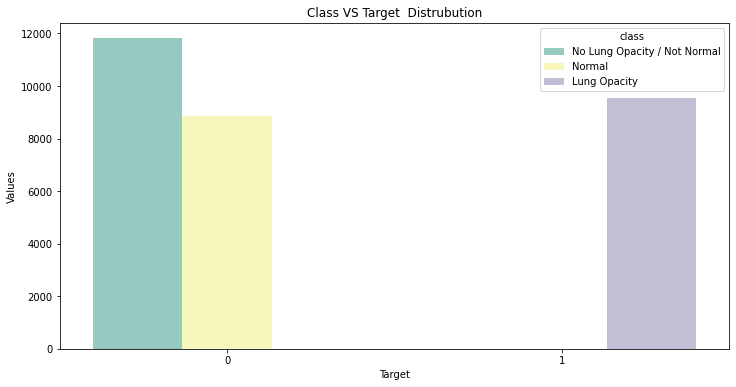

In [27]:
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = finaldf.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class, palette = 'Set3')
plt.title('Class VS Target  Distrubution')

From the above we can say that both Normal or No Lung Opacity class fall under Target Class 0 & Lung Opacity falls under Target Class 1.

In [26]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Pneumonia_Challenge/stage_2_train_images.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [27]:
import matplotlib.patches as patches

In [28]:
def inspectImages(data):

    img_data = list(data.T.to_dict().values())
    
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']
        dcm_file = '/content/stage_2_train_images/'+'{}.dcm'.format(patientImage)
        data_row_img_data = dcm.read_file(dcm_file)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(dcm_file)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\Bounds: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        label = data_row["class"]
        if not math.isnan(data_row['x']):
            x, y, width, height  =  data_row['x'],data_row['y'],data_row['width'],data_row['height']
            rect = patches.Rectangle((x, y),width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
            ax[i//3, i%3].add_patch(rect)

    plt.show()

Printing Sample images with Pneumonia

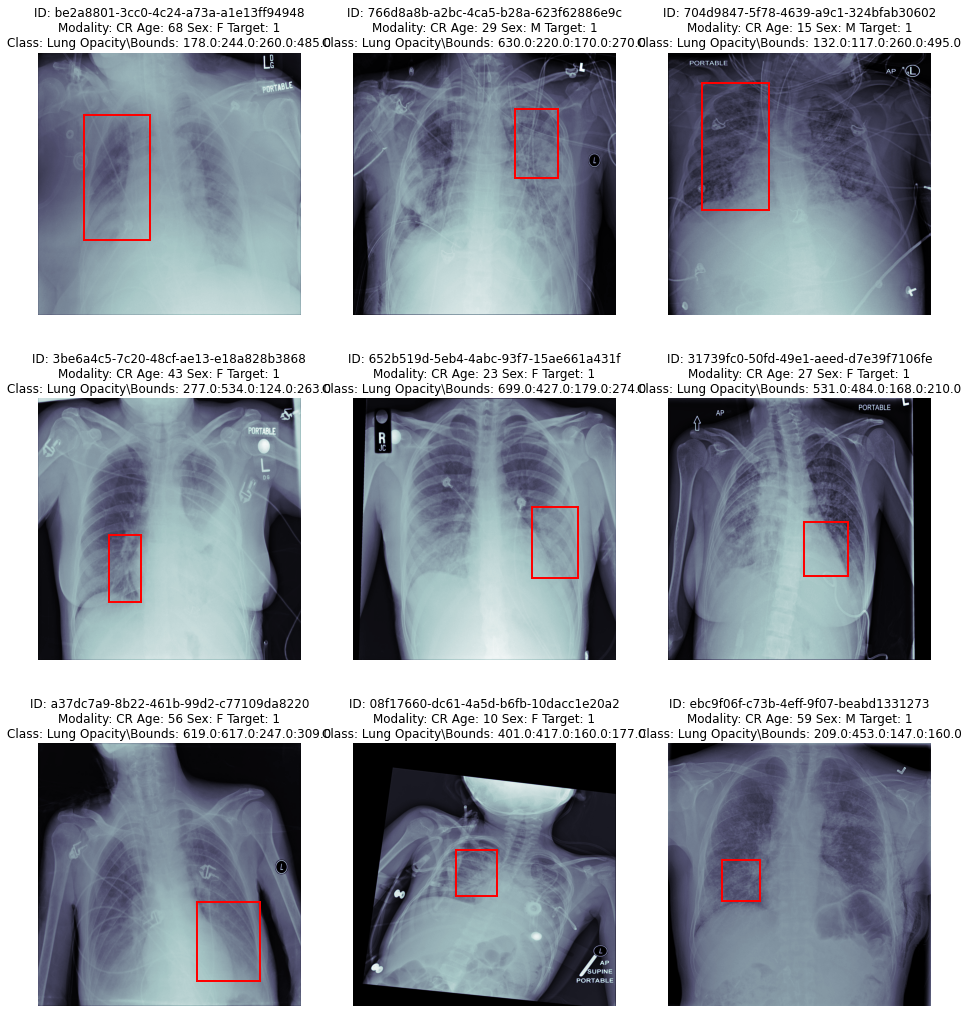

In [ ]:
inspectImages(finaldf[finaldf['Target']==1].sample(9))

Printing Sample Images without Pneumonia

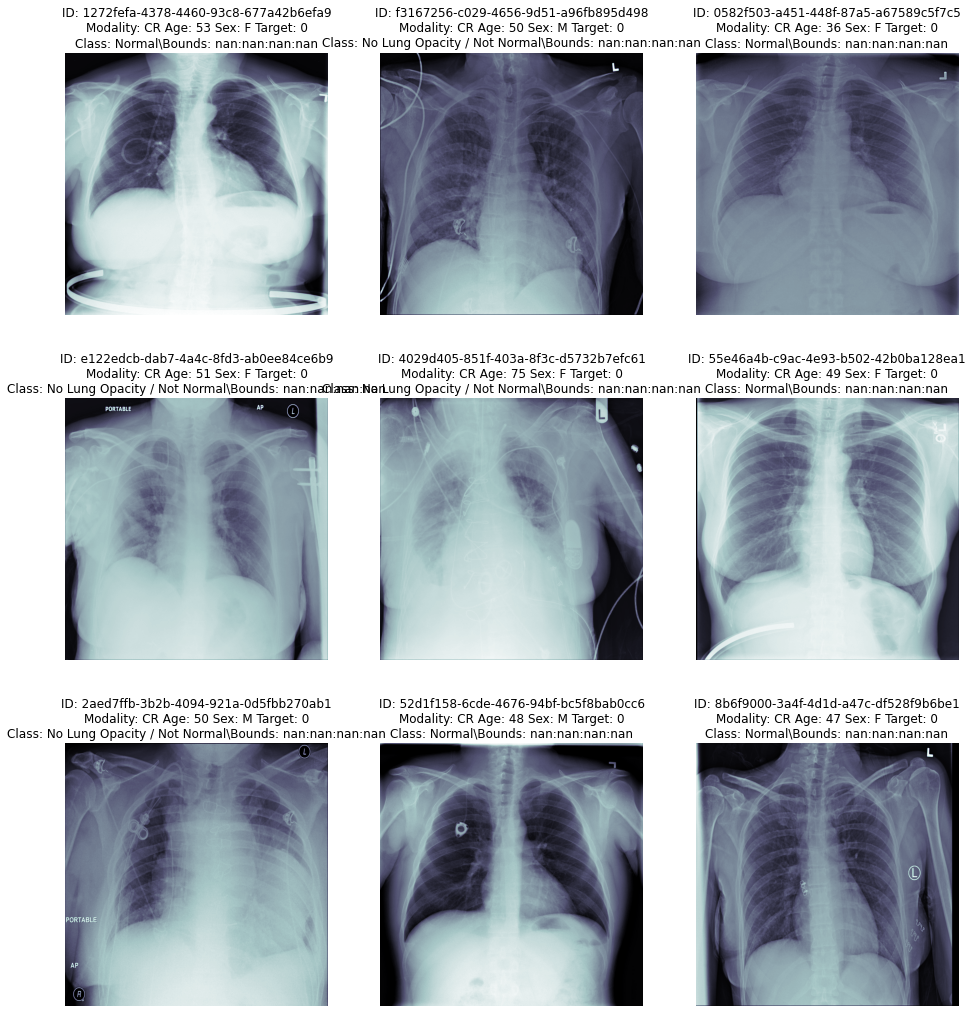

In [ ]:
inspectImages(finaldf[finaldf['Target']==0].sample(9))

### Reading Meta Data and Appending it to Training Set

In [29]:
def readDCIMData(rowData):
    dcm_file = '/content/stage_2_train_images/'+'{}.dcm'.format(rowData.patientId)
    dcm_data = dcm.read_file(dcm_file)
    img = dcm_data.pixel_array
    return dcm_data.PatientSex,dcm_data.PatientAge

In [30]:
finaldf['sex'], finaldf['age'] = zip(*finaldf.apply(readDCIMData, axis=1))

In [31]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
 7   sex        30227 non-null  object 
 8   age        30227 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 2.1+ MB


In [32]:
finaldf['age'] = finaldf.age.astype(int)

In [33]:
finaldf.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
patientId,30227,26684,3239951b-6211-4290-b237-3d9ad17176db,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x,9555.0,NaN,NaN,NaN,394.047724,204.574172,2.0,207.0,324.0,594.0,835.0
y,9555.0,NaN,NaN,NaN,366.83956,148.940488,2.0,249.0,365.0,478.5,881.0
width,9555.0,NaN,NaN,NaN,218.471376,59.289475,40.0,177.0,217.0,259.0,528.0
height,9555.0,NaN,NaN,NaN,329.269702,157.750755,45.0,203.0,298.0,438.0,942.0
Target,30227.0,NaN,NaN,NaN,0.316108,0.464963,0.0,0.0,0.0,1.0,1.0
class,30227,3,No Lung Opacity / Not Normal,11821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,30227,2,M,17216,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,30227.0,NaN,NaN,NaN,46.797764,16.89294,1.0,34.0,49.0,59.0,155.0


In [ ]:
finaldf.sex.value_counts()

M    17216
F    13011
Name: sex, dtype: int64

Text(0.5, 1.0, 'Sex VS Target')

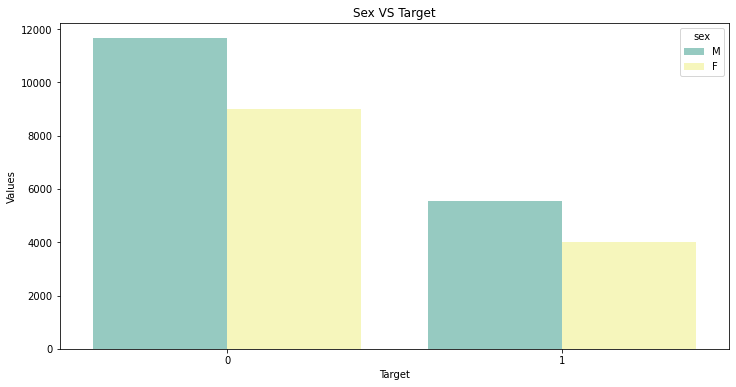

In [ ]:
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = finaldf.groupby('Target')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex VS Target')

Text(0.5, 1.0, 'Sex vs Class')

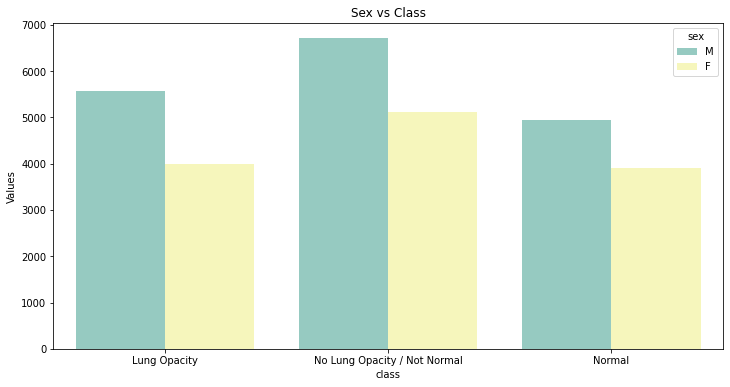

In [ ]:
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = finaldf.groupby('class')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex vs Class')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


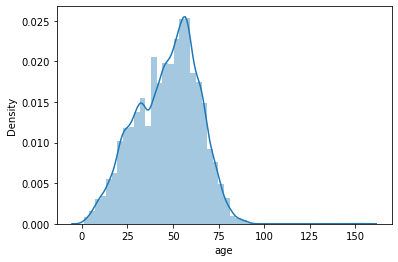

In [ ]:
sns.distplot(finaldf.age) 

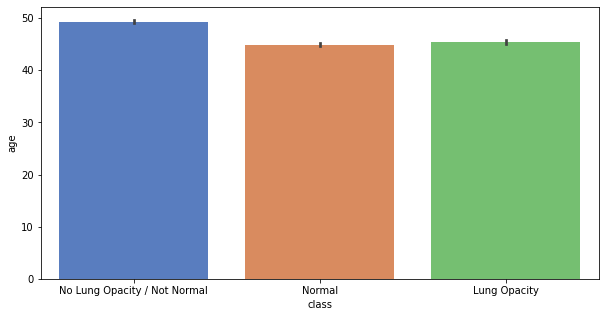

In [ ]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='class', y='age', data=finaldf, palette='muted') 

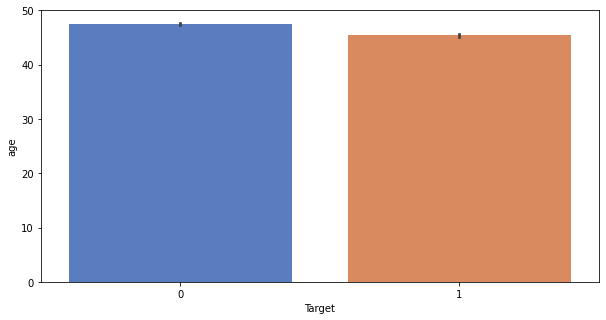

In [ ]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='Target', y='age', data=finaldf, palette='muted') 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


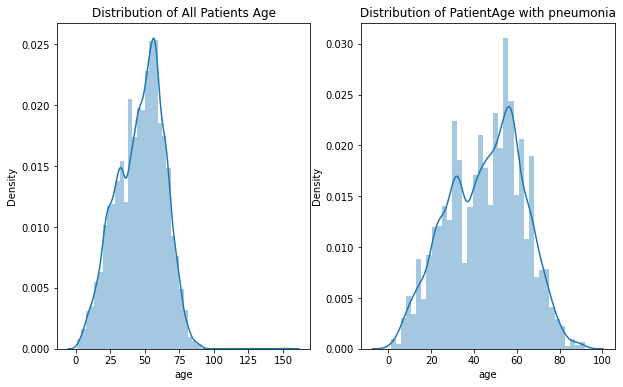

In [ ]:
fig = plt.figure(figsize = (10, 6))

ax = fig.add_subplot(121)
g = (sns.distplot(finaldf['age']).set_title('Distribution of All Patients Age'))

ax = fig.add_subplot(122)
g = (sns.distplot(finaldf.loc[finaldf['Target'] == 1, 'age']).set_title('Distribution of PatientAge with pneumonia'))

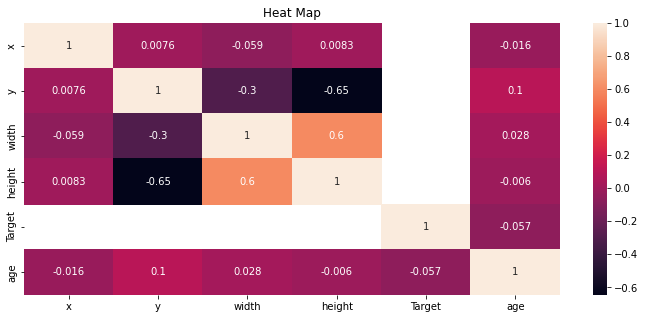

In [ ]:
corr = finaldf.corr()
plt.figure(figsize=(12,5))
plt.title('Heat Map')

sns.heatmap(corr,annot=True)

Building Basic CNN Model

In [ ]:
sampledf = finaldf.groupby('class', group_keys=False).apply(lambda x: x.sample(1000))

In [ ]:
sampledf["class"].value_counts()

Lung Opacity                    1000
No Lung Opacity / Not Normal    1000
Normal                          1000
Name: class, dtype: int64

In [ ]:
sampledf.info

<bound method DataFrame.info of                                   patientId      x      y  width  height  \
24660  dd830a3b-db9e-42bd-8d3a-8d52f40ddbde  262.0   92.0  145.0   245.0   
11853  7a32a64b-a415-4585-a110-981b913ac959  642.0  368.0  168.0   139.0   
3684   3a010152-9ce2-4780-bdd8-bac6fa101991  690.0  582.0  123.0   138.0   
4242   3d8ebf19-bf2c-4dff-9c25-25aa15d1ed88  149.0  542.0  317.0   201.0   
26444  ebdce693-283b-462c-825e-a182c6063a85  235.0  182.0  217.0   386.0   
...                                     ...    ...    ...    ...     ...   
25641  e575110c-c8f0-4bde-a5bf-17b714dc9d98    NaN    NaN    NaN     NaN   
5466   47024a50-f21e-4ea0-b036-e32c29bf5c5c    NaN    NaN    NaN     NaN   
15147  94691324-1788-4263-896a-6a9b5f4bde12    NaN    NaN    NaN     NaN   
30048  2e4e8d73-c213-47f2-a4f4-cebe3a6b2467    NaN    NaN    NaN     NaN   
20228  b9e7ae4f-33bb-4a8b-91f8-227ccc992a7e    NaN    NaN    NaN     NaN   

       Target         class sex  age  
24660       1  L

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input

In [ ]:
images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = '/content/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
    return tmpImages,tmpLabels

In [ ]:
images,labels = populateImage(sampledf)

In [ ]:
images.shape , labels.shape

((3000, 128, 128, 3), (3000,))

Text(0.5, 1.0, 'Sample X-ray')

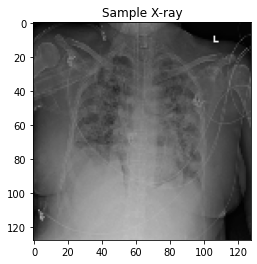

In [ ]:
plt.imshow(images[10])
plt.title('Sample X-ray')

In [ ]:
np.unique(labels),len(np.unique(labels))

(array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
       dtype='<U28'), 3)

In [34]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras import losses,optimizers
from tensorflow.keras.layers import Dense,  Activation, Flatten,Dropout,MaxPooling2D,BatchNormalization
import pandas as pd
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense ,LeakyReLU
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
enc = LabelBinarizer()
y2 = enc.fit_transform(labels)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.2, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.4, random_state=50)

In [ ]:
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

Basic CNN model

In [ ]:
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None
  model = Sequential()
  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))
  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))
  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))
  optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [ ]:
cnn = cnn_model(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

In [ ]:
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 5, 
                  validation_data = (X_val,y_val),
                  batch_size = 30)

Epoch 1/5
80/80 [==============================] - 12s 17ms/step - loss: 4.7201 - accuracy: 0.3600 - val_loss: 1.0939 - val_accuracy: 0.3458
Epoch 2/5
80/80 [==============================] - 1s 12ms/step - loss: 1.1599 - accuracy: 0.3671 - val_loss: 1.0988 - val_accuracy: 0.3542
Epoch 3/5
80/80 [==============================] - 1s 12ms/step - loss: 1.1077 - accuracy: 0.3733 - val_loss: 1.0799 - val_accuracy: 0.4333
Epoch 4/5
80/80 [==============================] - 1s 12ms/step - loss: 1.0870 - accuracy: 0.3779 - val_loss: 1.0983 - val_accuracy: 0.3542
Epoch 5/5
80/80 [==============================] - 1s 12ms/step - loss: 1.0898 - accuracy: 0.4008 - val_loss: 1.0870 - val_accuracy: 0.4000


In [ ]:
fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

12/12 [==============================] - 0s 12ms/step - loss: 1.0680 - accuracy: 0.4667
Test loss: 1.0679677724838257
Test accuracy: 0.46666666865348816


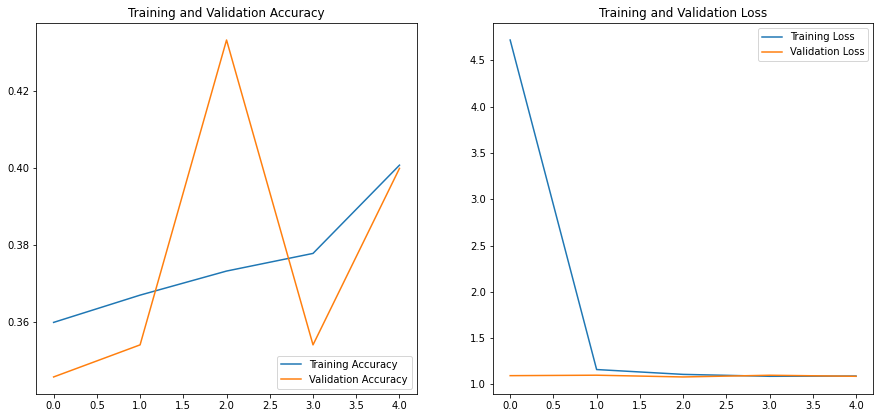

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
resultDF = createResultDf("CNN",acc[-1],fcl_accuracy)

12/12 [==============================] - 0s 4ms/step


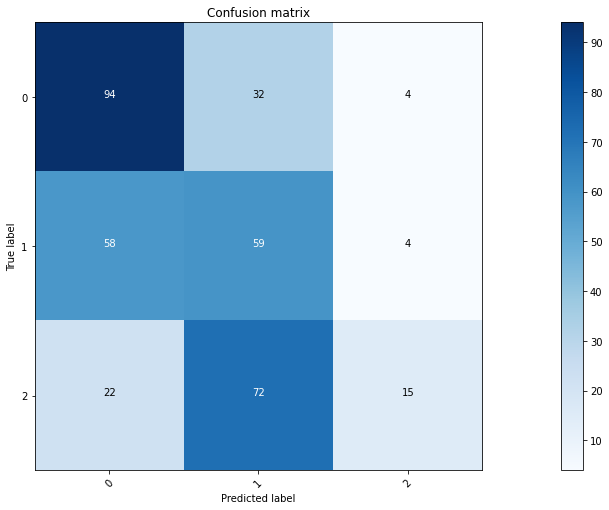

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = cnn.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [ ]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

12/12 [==============================] - 0s 5ms/step


,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN,0.400833,0.466667,0.361963,0.487603,0.415493,121


We can fine tune the basic CNN model. We will use 8500 samples for each class and an image size of 256. 

In [35]:
sampledf = finaldf.groupby('class', group_keys=False).apply(lambda x: x.sample(8500))

In [36]:
sampledf["class"].value_counts()

Lung Opacity                    8500
No Lung Opacity / Not Normal    8500
Normal                          8500
Name: class, dtype: int64

In [37]:
sampledf.info

<bound method DataFrame.info of                                   patientId      x      y  width  height  \
12830  81f89fe4-78c8-409b-8f4e-e20588818fa1  530.0  142.0  302.0   611.0   
18707  afe0a0c8-878e-48b9-bcd8-48526125fcdb  286.0  637.0  137.0   114.0   
227    061b44ff-fd22-473d-853f-81da70e14a63  596.0  121.0  307.0   620.0   
11914  7ab9c4d4-6582-42bf-ba0c-6f84b60b0c47  526.0  338.0  209.0   236.0   
7477   576a7e67-815c-47fd-a603-fcdab510ac78  678.0  253.0  252.0   452.0   
...                                     ...    ...    ...    ...     ...   
21273  c21278c7-0e37-4026-b9f1-14ec778903d7    NaN    NaN    NaN     NaN   
28409  fb7e027c-7111-41f9-b0d6-32d16ebc2c6b    NaN    NaN    NaN     NaN   
28128  f95dd310-be6f-40b1-a6c5-b293aef2357f    NaN    NaN    NaN     NaN   
1863   197146c0-dfe6-4938-ab89-5fbef34150fc    NaN    NaN    NaN     NaN   
20240  b9ff75c0-2087-4791-84ee-e49811ca4889    NaN    NaN    NaN     NaN   

       Target         class sex  age  
12830       1  L

In [38]:
from tensorflow.keras.applications.mobilenet import preprocess_input

In [39]:
images = []
ADJUSTED_IMAGE_SIZE = 256
imageList = []
classLabels = []
labels = []
originalImage = []
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = '/content/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
    return tmpImages,tmpLabels

In [40]:
images,labels = populateImage(sampledf)

In [41]:
images.shape , labels.shape

((25500, 256, 256, 3), (25500,))

In [42]:
np.unique(labels),len(np.unique(labels))

(array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
       dtype='<U28'), 3)

In [43]:
enc = LabelBinarizer()
y2 = enc.fit_transform(labels)

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.2, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.4, random_state=50)

In [45]:
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

In [50]:
cnnfinetuned = Sequential()
cnnfinetuned.add(Conv2D(32, (3, 3), input_shape = (ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE, 3), activation = 'relu', padding = 'same'))
cnnfinetuned.add(MaxPooling2D(pool_size = (2, 2)))
cnnfinetuned.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
cnnfinetuned.add(MaxPooling2D(pool_size = (2, 2)))
cnnfinetuned.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
cnnfinetuned.add(MaxPooling2D(pool_size = (2, 2)))
cnnfinetuned.add(Flatten())
cnnfinetuned.add(Dense(units = 512, activation = 'relu'))
cnnfinetuned.add(Dropout(0.5))
cnnfinetuned.add(Dense(units = 128, activation = 'relu'))
cnnfinetuned.add(Dense(units = 3, activation = 'softmax'))
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)

In [51]:
cnnfinetuned.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [52]:
cnnfinetuned.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', mode='auto', patience=9,  restore_best_weights=True)

In [ ]:
history=cnnfinetuned.fit(X_train, y_train, batch_size=100, epochs=20, validation_data=(X_test, y_test),callbacks=es)

Epoch 1/20
204/204 [==============================] - 8s 38ms/step - loss: 0.9852 - accuracy: 0.5064 - val_loss: 0.9442 - val_accuracy: 0.5324
Epoch 2/20
204/204 [==============================] - 7s 33ms/step - loss: 0.8842 - accuracy: 0.5802 - val_loss: 0.9486 - val_accuracy: 0.5340
Epoch 3/20
204/204 [==============================] - 7s 32ms/step - loss: 0.7873 - accuracy: 0.6374 - val_loss: 0.8938 - val_accuracy: 0.5833
Epoch 4/20
204/204 [==============================] - 7s 33ms/step - loss: 0.6719 - accuracy: 0.6993 - val_loss: 0.9089 - val_accuracy: 0.5980
Epoch 5/20
204/204 [==============================] - 7s 33ms/step - loss: 0.5734 - accuracy: 0.7544 - val_loss: 0.9470 - val_accuracy: 0.6049
Epoch 6/20
204/204 [==============================] - 7s 33ms/step - loss: 0.4775 - accuracy: 0.8016 - val_loss: 1.0464 - val_accuracy: 0.5954
Epoch 7/20
204/204 [==============================] - 7s 32ms/step - loss: 0.3820 - accuracy: 0.8442 - val_loss: 1.1010 - val_accuracy: 0.6062

In [ ]:
fcl_loss, fcl_accuracy = cnnfinetuned.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

96/96 [==============================] - 1s 7ms/step - loss: 2.0625 - accuracy: 0.6225
Test loss: 2.0624799728393555
Test accuracy: 0.6225489974021912


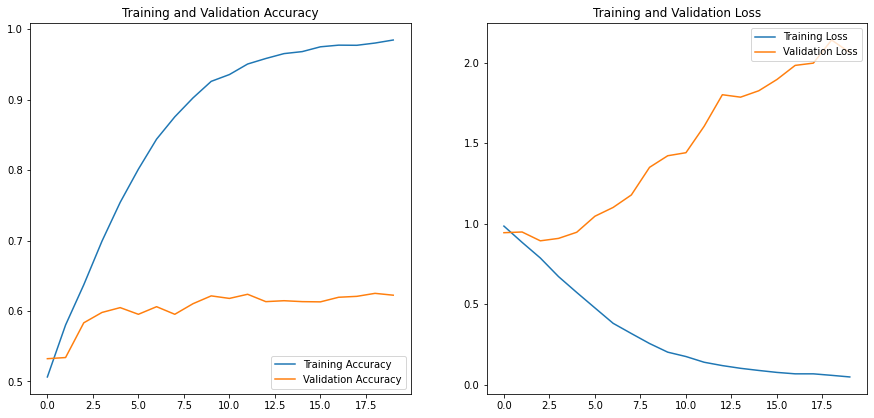

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
resultDF = createResultDf("CNN Fine Tuned",acc[-1],fcl_accuracy)

96/96 [==============================] - 1s 6ms/step


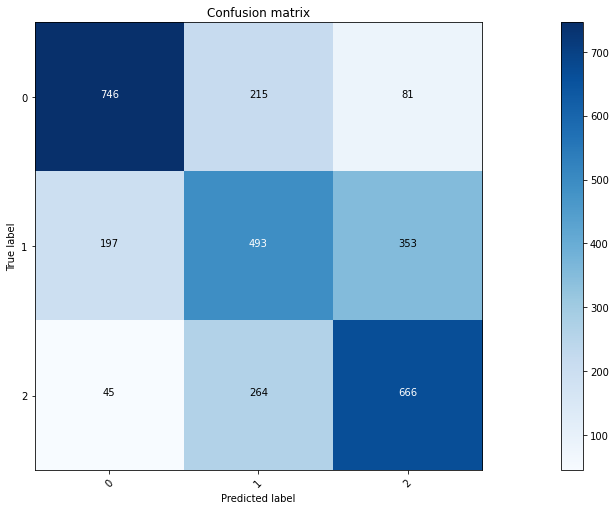

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = cnnfinetuned.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [ ]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnnfinetuned.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

96/96 [==============================] - 1s 6ms/step


,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN Fine Tuned,0.985,0.622549,0.507202,0.472675,0.48933,1043


### VGG16 Model

In [46]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False

train_ds = preprocess_input(X_train) 
train_val_df = preprocess_input(X_val)

In [47]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(30, activation='relu')
dense_layer_3 = layers.Dense(20, activation='relu')
dense_layer_4 = layers.Dense(10, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')


cnn_VGG16_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    dense_layer_3,
    dense_layer_4,
    prediction_layer
])

In [48]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_VGG16_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

cnn_VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 50)                1638450   
                                                                 
 dense_1 (Dense)             (None, 30)                1530      
                                                                 
 dense_2 (Dense)             (None, 20)                620       
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
 dense_4 (Dense)             (None, 3)                 3

In [49]:
es = EarlyStopping(monitor='val_accuracy', mode='auto', patience=9,  restore_best_weights=True)

In [50]:
history = cnn_VGG16_model.fit(train_ds, y_train, epochs=25, validation_data=(train_val_df,y_val) ,callbacks=es)

Epoch 1/25
638/638 [==============================] - 45s 45ms/step - loss: 0.5891 - accuracy: 0.5765 - val_loss: 0.5226 - val_accuracy: 0.6245
Epoch 2/25
638/638 [==============================] - 25s 40ms/step - loss: 0.4733 - accuracy: 0.6410 - val_loss: 0.4413 - val_accuracy: 0.6559
Epoch 3/25
638/638 [==============================] - 25s 40ms/step - loss: 0.3978 - accuracy: 0.7058 - val_loss: 0.4379 - val_accuracy: 0.7078
Epoch 4/25
638/638 [==============================] - 25s 40ms/step - loss: 0.3551 - accuracy: 0.7564 - val_loss: 0.4950 - val_accuracy: 0.6578
Epoch 5/25
638/638 [==============================] - 25s 40ms/step - loss: 0.3189 - accuracy: 0.7893 - val_loss: 0.4605 - val_accuracy: 0.7201
Epoch 6/25
638/638 [==============================] - 25s 40ms/step - loss: 0.2762 - accuracy: 0.8229 - val_loss: 0.4861 - val_accuracy: 0.7088
Epoch 7/25
638/638 [==============================] - 25s 40ms/step - loss: 0.2481 - accuracy: 0.8465 - val_loss: 0.5238 - val_accuracy:

In [51]:
test_ds = preprocess_input(X_test) 
fcl_loss, fcl_accuracy = cnn_VGG16_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

96/96 [==============================] - 4s 40ms/step - loss: 0.5236 - accuracy: 0.7131
Test loss: 0.5236095786094666
Test accuracy: 0.713071882724762


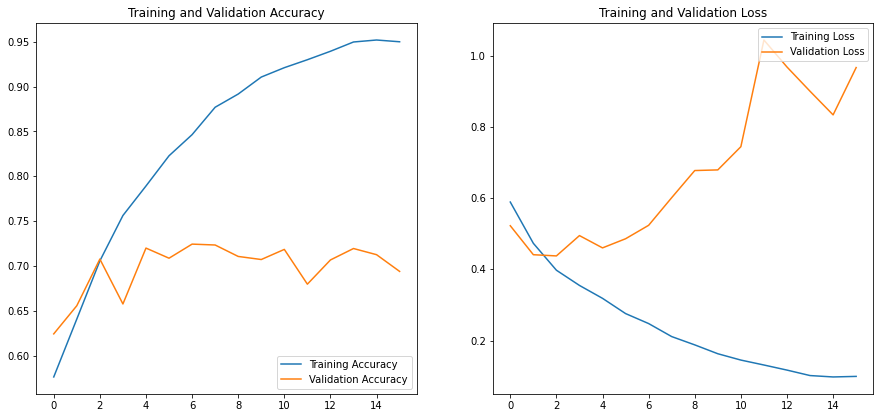

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(16)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
resultDF = createResultDf("CNN VGG16 model",acc[-1],fcl_accuracy)

96/96 [==============================] - 3s 29ms/step


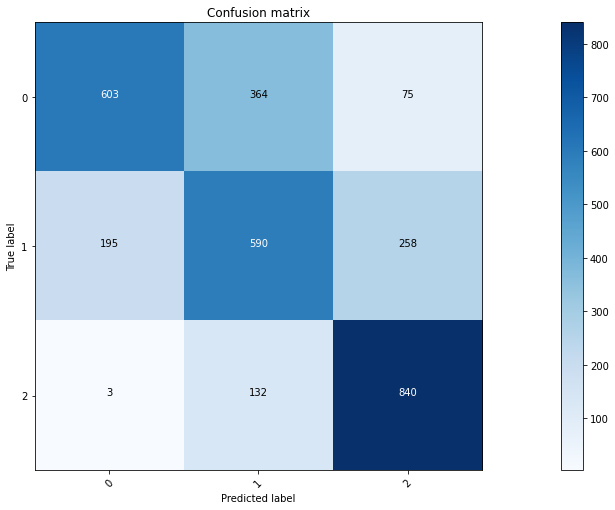

In [54]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = cnn_VGG16_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [55]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn_VGG16_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

96/96 [==============================] - 3s 29ms/step


,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN VGG16 model,0.949951,0.713072,0.543278,0.565676,0.554251,1043


Model ResNet50

In [53]:
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

resnet_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=X_train[0].shape)

train_ds = preprocess_input(X_train) 
train_val_df = preprocess_input(X_val)


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(40, activation='relu')
dense_layer_3 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')

cnn_resnet_model = models.Sequential([
    resnet_base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    dense_layer_3,
    prediction_layer
])

94765736/94765736 [==============================] - 0s 0us/step


In [54]:
cnn_resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_3 (Dense)             (None, 50)                6553650   
                                                                 
 dense_4 (Dense)             (None, 40)                2040      
                                                                 
 dense_5 (Dense)             (None, 32)                1312      
                                                                 
 dense_6 (Dense)             (None, 3)                 99        
                                                                 
Total params: 30,144,813
Trainable params: 30,091,693


In [55]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_resnet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='auto', patience=9,  restore_best_weights=True)

history =cnn_resnet_model.fit(train_ds, y_train, epochs=25, validation_data=(train_val_df,y_val), callbacks=es)

Epoch 1/25
638/638 [==============================] - 82s 91ms/step - loss: 0.4943 - accuracy: 0.6417 - val_loss: 0.9226 - val_accuracy: 0.5221
Epoch 2/25
638/638 [==============================] - 54s 85ms/step - loss: 0.4244 - accuracy: 0.6940 - val_loss: 0.4499 - val_accuracy: 0.6672
Epoch 3/25
638/638 [==============================] - 54s 85ms/step - loss: 0.4070 - accuracy: 0.7090 - val_loss: 0.4913 - val_accuracy: 0.6314
Epoch 4/25
638/638 [==============================] - 54s 85ms/step - loss: 0.3913 - accuracy: 0.7252 - val_loss: 0.6149 - val_accuracy: 0.6186
Epoch 5/25
638/638 [==============================] - 54s 85ms/step - loss: 0.3781 - accuracy: 0.7345 - val_loss: 0.4510 - val_accuracy: 0.6775
Epoch 6/25
638/638 [==============================] - 54s 85ms/step - loss: 0.3699 - accuracy: 0.7458 - val_loss: 0.5239 - val_accuracy: 0.6025
Epoch 7/25
638/638 [==============================] - 54s 84ms/step - loss: 0.3545 - accuracy: 0.7584 - val_loss: 0.6860 - val_accuracy:

In [58]:
test_ds = preprocess_input(X_test) 
fcl_loss, fcl_accuracy = cnn_resnet_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

96/96 [==============================] - 3s 32ms/step - loss: 0.5221 - accuracy: 0.7173
Test loss: 0.5220577716827393
Test accuracy: 0.7173202633857727


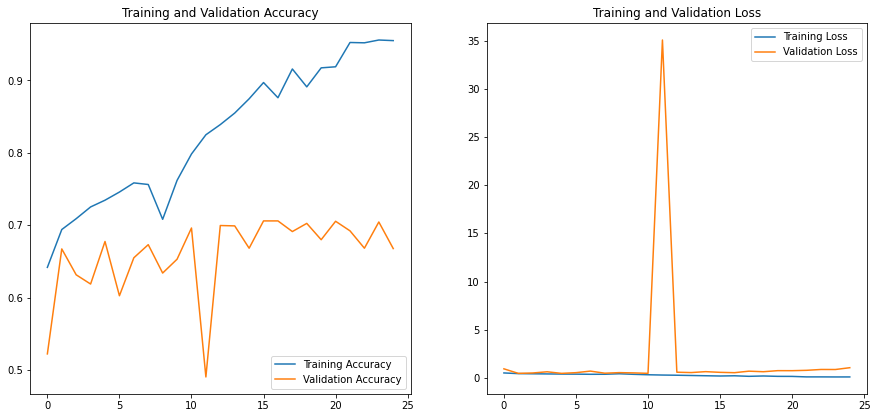

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(25)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
resultDF = createResultDf("CNN ResNet50 model",acc[-1],fcl_accuracy)

96/96 [==============================] - 3s 23ms/step


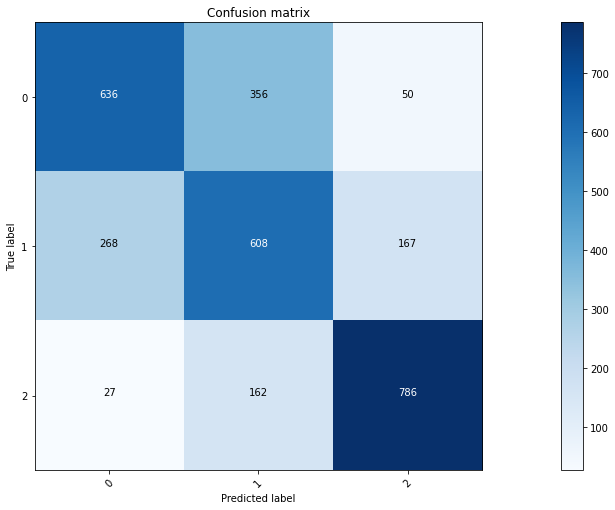

In [61]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = cnn_resnet_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [62]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn_resnet_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

96/96 [==============================] - 2s 23ms/step


,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN ResNet50 model,0.955098,0.71732,0.539964,0.582934,0.560627,1043


### Bounding Box Prediction

In [57]:
labelsdf = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pneumonia_Challenge/stage_2_train_labels.csv")

In [58]:
train_CombinedData = labelsdf[0:24000]
validate_CombinedData = labelsdf[24000:30000]

train_CombinedData.fillna(0, inplace=True)
validate_CombinedData.fillna(0, inplace=True)

In [59]:
train_CombinedData.Target.value_counts()

0    16008
1     7992
Name: Target, dtype: int64

In [60]:
validate_CombinedData.Target.value_counts()

0    4542
1    1458
Name: Target, dtype: int64

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Pneumonia_Challenge/stage_2_train_images.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [92]:
from tensorflow.keras.applications.mobilenet import preprocess_input 

#
BATCH_SIZE = 10

IMAGE_SIZE = 256


IMG_WIDTH = 1024
IMG_HEIGHT = 1024


class TrainGenerator(Sequence):

    def __init__(self,  _labels):       
        self.pids = _labels["patientId"].to_numpy()
        self.coords = _labels[["x", "y", "width", "height"]].to_numpy()
        self.coords = self.coords * IMAGE_SIZE / IMG_WIDTH
        

    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)
    
    
    

    def __doHistogramEqualization(self,img):
        histogram_array = np.bincount(img.flatten(), minlength=256)
        num_pixels = np.sum(histogram_array)
        histogram_array = histogram_array/num_pixels
        chistogram_array = np.cumsum(histogram_array)
        transform_map = np.floor(255 * chistogram_array).astype(np.uint8)
        img_list = list(img.flatten())
        eq_img_list = [transform_map[p] for p in img_list]
        img = np.reshape(np.asarray(eq_img_list), img.shape)

        return img

    def __getitem__(self, idx): # Get a batch
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords
        batch_pids = self.pids[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image pids    
        
        batch_images = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE))
        for _indx, _pid in enumerate(batch_pids):
            _path = '/content/stage_2_train_images/'+'{}.dcm'.format(_pid)
            _imgData = dcm.read_file(_path)

            img = _imgData.pixel_array 
            resized_img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE), interpolation = cv2.INTER_AREA)
            
            resized_img = self.__doHistogramEqualization(resized_img)
        
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2])
            height = int(batch_coords[_indx, 3])
            
            batch_masks[_indx][y:y+height, x:x+width] = 1

        return batch_images, batch_masks

In [93]:
trainUNetDataGen = TrainGenerator( train_CombinedData)
validateUNetDataGen = TrainGenerator( validate_CombinedData)

In [94]:
def showMaskedImage(_imageSet, _maskSet, _index) :
    maskImage = _imageSet[_index]

    maskImage[:,:,0] = _maskSet[_index] * _imageSet[_index][:,:,0]
    maskImage[:,:,1] = _maskSet[_index] * _imageSet[_index][:,:,1]
    maskImage[:,:,2] = _maskSet[_index] * _imageSet[_index][:,:,2]

    plt.imshow(maskImage[:,:,0])

Text(0.5, 1.0, 'X-ray with mask')

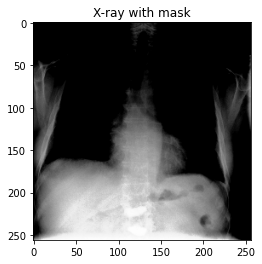

In [95]:
imageSet0 = trainUNetDataGen[1][0][1]
plt.imshow(imageSet0)
plt.title('X-ray with mask')

Text(0.5, 1.0, 'Mask')

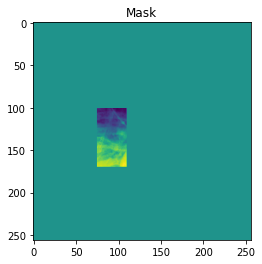

In [96]:
imageSet0 = trainUNetDataGen[2][0]
maskSet0 = trainUNetDataGen[2][1]    
showMaskedImage(imageSet0, maskSet0, 5)
plt.title('Mask')

In [97]:
LR = 1e-4

In [98]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization ,Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet , VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D

UNET USING MobileNet

In [99]:
ALPHA = 1.0
def create_UNetModelUsingMobileNet(trainable=True):
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights="imagenet") 
    for layer in model.layers:
        layer.trainable = trainable
    convLayer_112by112 = model.get_layer("conv_pw_1_relu").output
    convLayer_56by56 = model.get_layer("conv_pw_3_relu").output
    convLayer_28by28 = model.get_layer("conv_pw_5_relu").output
    convLayer_14by14 = model.get_layer("conv_pw_11_relu").output
    convLayer_7by7 = model.get_layer("conv_pw_13_relu").output
    x = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    x = Concatenate()([UpSampling2D()(x), convLayer_28by28])
    x = Concatenate()([UpSampling2D()(x), convLayer_56by56])
    x = Concatenate()([UpSampling2D()(x), convLayer_112by112])
    x = UpSampling2D(name="unet_last")(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(x)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x) 

    return Model(inputs=model.input, outputs=x)

In [100]:
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
model = create_UNetModelUsingMobileNet(input_shape)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 128, 128, 32  128         ['conv1[0][0]']                  
                                )                                                           

In [101]:
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + tf.keras.backend.epsilon()) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())

In [102]:
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [103]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=False)
]

In [104]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [119]:
train_steps = len(trainUNetDataGen)//BATCH_SIZE
valid_steps = len(validateUNetDataGen)//BATCH_SIZE

if len(trainUNetDataGen) % BATCH_SIZE != 0:
    train_steps += 1
if len(validateUNetDataGen) % BATCH_SIZE != 0:
    valid_steps += 1


history = model.fit(trainUNetDataGen,
                        epochs=25,
                        steps_per_epoch=train_steps,
                        validation_data=validateUNetDataGen,
                        callbacks=callbacks,
                        use_multiprocessing=True,
                        workers=4,
                        validation_steps=valid_steps,                      
                        shuffle=True)

Epoch 1/25
240/240 [==============================] - 87s 359ms/step - loss: 0.6429 - dice_coef: 0.3571 - recall_2: 0.5683 - precision_2: 0.3157 - val_loss: 0.7754 - val_dice_coef: 0.2246 - val_recall_2: 0.7893 - val_precision_2: 0.1597 - lr: 1.0000e-05
Epoch 2/25
240/240 [==============================] - 73s 297ms/step - loss: 0.6432 - dice_coef: 0.3568 - recall_2: 0.5141 - precision_2: 0.3435 - val_loss: 0.7722 - val_dice_coef: 0.2278 - val_recall_2: 0.7804 - val_precision_2: 0.1643 - lr: 1.0000e-05
Epoch 3/25
240/240 [==============================] - 99s 404ms/step - loss: 0.6252 - dice_coef: 0.3748 - recall_2: 0.5357 - precision_2: 0.3566 - val_loss: 0.7611 - val_dice_coef: 0.2389 - val_recall_2: 0.7658 - val_precision_2: 0.1757 - lr: 1.0000e-05
Epoch 4/25
240/240 [==============================] - 101s 414ms/step - loss: 0.6243 - dice_coef: 0.3757 - recall_2: 0.5148 - precision_2: 0.3561 - val_loss: 0.7612 - val_dice_coef: 0.2388 - val_recall_2: 0.7871 - val_precision_2: 0.1689 

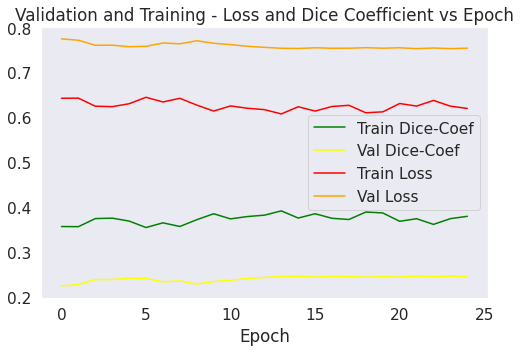

In [154]:
plt.figure(figsize=(8, 5))
plt.grid(False)
plt.plot(history.history['dice_coef'],     label='Train Dice-Coef',      color = "green" );
plt.plot(history.history['val_dice_coef'], label='Val Dice-Coef',  color = "yellow");
plt.plot(history.history['loss'],         label='Train Loss',          color = "red"   );
plt.plot(history.history['val_loss'],     label='Val Loss',      color = "orange");
plt.title("Validation and Training - Loss and Dice Coefficient vs Epoch")
plt.xlabel("Epoch")
plt.legend();

### From the above we can say that the model is underfitting.

### Using better image resolution, image augmentation, hyperparameter tuning will help in increasing the performance.

In [155]:
test_CombinedData = labelsdf[300:320]
test_CombinedData.fillna(0, inplace=True)

In [156]:
test_CombinedData.Target.value_counts()

1    12
0     8
Name: Target, dtype: int64

In [157]:
testUNetDataGen = TrainGenerator(test_CombinedData)

In [158]:
test_steps = (len(testUNetDataGen)//BATCH_SIZE)
if len(testUNetDataGen) % BATCH_SIZE != 0:
    test_steps += 1

model.evaluate(testUNetDataGen)

2/2 [==============================] - 1s 263ms/step - loss: 0.5325 - dice_coef: 0.4675 - recall_2: 0.4217 - precision_2: 0.5822


[0.5324525833129883,
 0.4675474166870117,
 0.42171961069107056,
 0.5821609497070312]

In [159]:
pred_mask = model.predict(testUNetDataGen)

2/2 [==============================] - 1s 259ms/step


In [160]:
test_CombinedData = test_CombinedData.reset_index()

In [161]:
from sklearn.metrics import confusion_matrix
y_pred = []
y_True = []
imageList = []
predMaskTemp = []

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

def getPredictions(test_CombinedData):
    masks = np.zeros((int(test_CombinedData.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))

    for index, row in test_CombinedData.iterrows():
        patientId = row.patientId
        classlabel = row["Target"]
        dcm_file = '/content/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        resized_img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH), interpolation = cv2.INTER_LINEAR)
        predMaskTemp.append(pred_mask[index])
        iou = (pred_mask[index] > 0.5) * 1.0
        y_pred.append((1 in iou) * 1)
        imageList.append(resized_img)
        y_True.append(classlabel)
        x_scale = IMAGE_HEIGHT / 1024
        y_scale = IMAGE_WIDTH / 1024

        if(classlabel == 1):
            x = int(np.round(row['x'] * x_scale))
            y = int(np.round(row['y'] * y_scale))
            w = int(np.round(row['width'] * x_scale))
            h = int(np.round(row['height'] * y_scale))
            masks[index][y:y+h, x:x+w] = 1

        
        
    tmpImages = np.array(imageList)
    tmpMask = np.array(predMaskTemp)
    originalMask = np.array(masks)
    return (y_True,y_pred,tmpImages,tmpMask ,originalMask)
    
def print_confusion_matrix(y_true, y_pred):
    array = confusion_matrix(y_true, y_pred)    
    df_cm = pd.DataFrame(array, range(2), range(2))

    print("Total samples = ", len(test_CombinedData))
    
    sns.set(font_scale=1.4); # for label size
    result = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cbar=False); 

    labels = ['TN=','FP=','FN=','TP=']
    i=0
    for t in result.texts:
        t.set_text(labels[i] + t.get_text())
        i += 1
    
    plt.xlabel("Predicted Values")
    plt.ylabel('True Values')
    plt.show()
    return


In [162]:
y_true,y_pred ,imagelist , maskList , originalMask = getPredictions(test_CombinedData)

Text(0.5, 1.0, 'Sample X-ray')

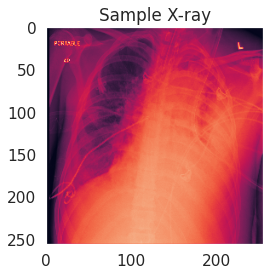

In [163]:
dcm_file = '/content/stage_2_train_images/'+'{}.dcm'.format('9358d1c5-ba61-4150-a233-41138208a3f9')
dcm_data = dcm.read_file(dcm_file)
img = dcm_data.pixel_array
plt.grid(False)
plt.imshow(imagelist[12])
plt.title('Sample X-ray')

Text(0.5, 0, 'Pneumonia 1:')

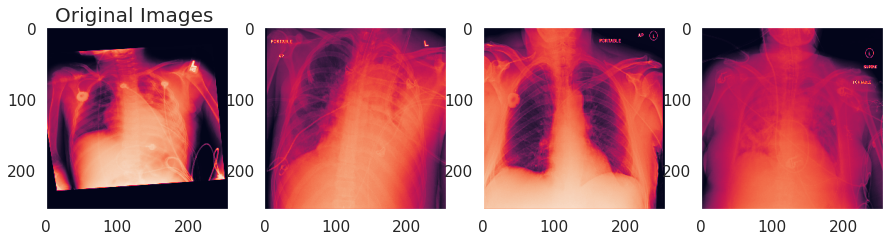

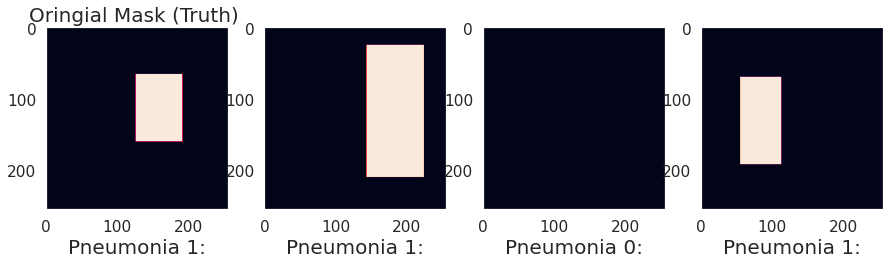

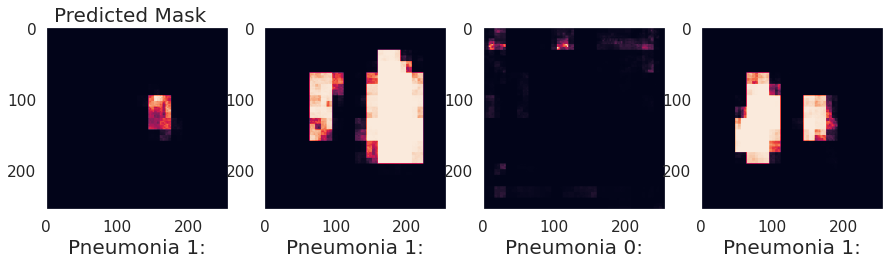

In [168]:
fig = plt.figure(figsize=(15, 15))

a = fig.add_subplot(1, 4, 1)

imgplot = plt.imshow(imagelist[1])
plt.grid(False)
a.set_title('Original Images ',fontsize=20)


a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(imagelist[12])
plt.grid(False)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(imagelist[13])
plt.grid(False)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(imagelist[15])
plt.grid(False)


fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)

imgplot = plt.imshow(originalMask[1])
plt.grid(False)
a.set_title('Oringial Mask (Truth) ',fontsize=20)

a.set_xlabel('Pneumonia {}:'.format(y_true[1]), fontsize=20)


a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(originalMask[12])
plt.grid(False)
a.set_xlabel('Pneumonia {}:'.format(y_true[12]), fontsize=20)


a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(originalMask[13])
plt.grid(False)
a.set_xlabel('Pneumonia {}:'.format(y_true[13]), fontsize=20)


a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(originalMask[15])
plt.grid(False)
a.set_xlabel('Pneumonia {}:'.format(y_true[15]), fontsize=20)



fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
a.set_title('Predicted Mask  ',fontsize=20)
imgplot = plt.imshow(maskList[1])
plt.grid(False)
a.set_xlabel('Pneumonia {}:'.format(y_pred[1]), fontsize=20)

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(maskList[12])
plt.grid(False)
a.set_xlabel('Pneumonia {}:'.format(y_pred[12]), fontsize=20)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(maskList[13])
plt.grid(False)
a.set_xlabel('Pneumonia {}:'.format(y_pred[13]), fontsize=20)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(maskList[15])
plt.grid(False)
a.set_xlabel('Pneumonia {}:'.format(y_pred[15]), fontsize=20)

Total samples =  20


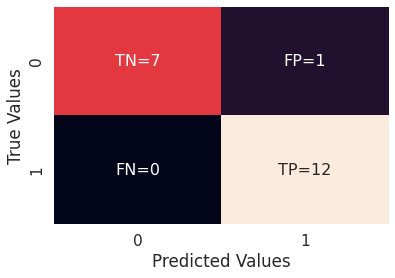

In [169]:
print_confusion_matrix(y_true,y_pred )

In [170]:
from sklearn.metrics import classification_report

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.92      1.00      0.96        12

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20



From the above we can see that the performance has improved.
- 95% accuracy.
- No False Negatives
- 95% Recall and 95% Precision.

Pickle model

In [171]:
import pickle

In [172]:
# Save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))